In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import timeit
import pandas as pd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
def trans_im(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

In [6]:
class SimCLRTransform(object):
    def __init__(self,input_height,s):
        self.input_height = input_height
        self.color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s) 

        data_transforms = [
            transforms.RandomResizedCrop(size=self.input_height),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([self.color_jitter], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]

        self.transform = transforms.Compose(data_transforms)

    def __call__(self, sample):
        xi = self.transform(sample)
        xj = self.transform(sample)

        return xi, xj

In [7]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=SimCLRTransform(32, 0.5))
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=SimCLRTransform(32, 0.5))

Files already downloaded and verified
Files already downloaded and verified


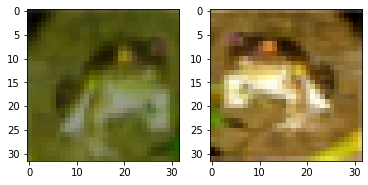

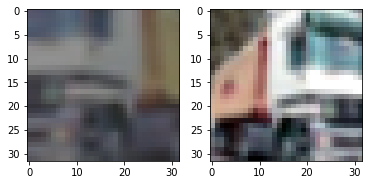

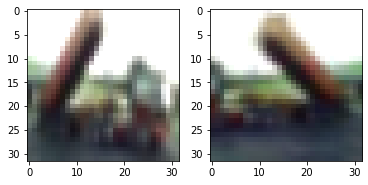

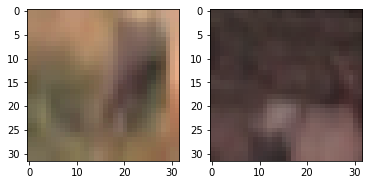

In [5]:
for i in range(4):
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(trans_im(trainset[i][0][0]))
    ax2.imshow(trans_im(trainset[i][0][1]))
    plt.show()

In [6]:
def calculate_loss(data, tau):
    sum_loss = 0
    data_size = int(data.size()[0] / 2)
    for i in range(data_size):
        pos_data = data[np.r_[i, i+data_size]]

        if i == (data_size - 1):
            neg_data = data[np.r_[0:i, i+1:i+data_size]]
        else:
            neg_data = data[np.r_[0:i, i+1:(i+data_size),(i+data_size+1):data.size()[0]]]

        pos_sim = torch.dot(pos_data[0], pos_data[1]) / (torch.norm(pos_data[0]) * torch.norm(pos_data[1]))
        neg_sim_ik = (neg_data @ pos_data[0]) / (torch.norm(pos_data[0]) * torch.norm(neg_data, dim=1)) 
        neg_sim_jk = (neg_data @ pos_data[1]) / (torch.norm(pos_data[1]) * torch.norm(neg_data, dim=1))  
        l_ik = -torch.log(torch.exp(pos_sim / tau) / torch.exp(neg_sim_ik / tau).sum())
        l_jk = -torch.log(torch.exp(pos_sim / tau) / torch.exp(neg_sim_jk / tau).sum())
        sum_loss += (l_ik + l_jk)
    return (sum_loss / data.size()[0])


In [7]:
check_data = torch.rand(60, 3)
calculate_loss(check_data, 1)

tensor(4.0637)

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=128):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc1 = nn.Linear(512, 512)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc2 = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out
    
    def feature_extractor(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        return out

def ResNet18():
    return ResNet(ResidualBlock)

In [70]:
batch_size = 256
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [15]:
normal_trans = transform = transforms.Compose(
                          [transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset_wa = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=normal_trans)
testset_wa = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=normal_trans)

batch_size_wa = 256
trainloader_wa = torch.utils.data.DataLoader(trainset_wa, batch_size=batch_size_wa,
                                          shuffle=False, num_workers=2)
testloader_wa = torch.utils.data.DataLoader(testset_wa, batch_size=batch_size_wa,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = ResNet18()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)

X_train = []
y_train = []

X_test = []
y_test = []
df_loss = pd.DataFrame(columns={'epoch', 'training_loss', 'test_loss'})

for epoch in range(300):
    train_loss = 0
    test_loss = 0
    for i, data in enumerate(trainloader, 0):
        input_X, label = data[0][0].to(device), data[0][1].to(device)
        optimizer.zero_grad()

        input_X = net(input_X)
        loss = calculate_loss(torch.vstack((input_X, label)), 0.5)
        loss.backward()
        optimizer.step()
      
        train_loss += loss.item()
    print(f'epoch: {epoch + 1}, training_loss: {np.round(train_loss / i, 3)}')

    #test_loss
    with torch.no_grad():
        for j, data in enumerate(testloader, 0):
            input_X, label = data[0][0].to(device), data[0][1].to(device)
            outputs_1 = net(input_X)
            loss = calculate_loss(torch.vstack((input_X, label)), 0.5)
            test_loss += loss.item()
    print(f'test_loss: {np.round(test_loss / j, 3)}')

    df_loss = df_loss.append({'epoch': epoch + 1, 
                              'training_loss': train_loss / i,
                              'test_loss': test_loss / i},ignore_index=True)

    #feature extraction
    if (epoch + 1) % 30 == 0:
        for data in trainloader_wa:
            samples, labels = data[0].to(device), data[1].to(device)
            features = list(net.feature_extractor(samples).detach().cpu().numpy())
            X_train.extend(features)
            y_train.extend(list(labels.detach().cpu().numpy()))

        for data in testloader_wa:
            samples, labels = data[0].to(device), data[1].to(device)
            features = list(net.feature_extractor(samples).detach().cpu().numpy())
            X_test.extend(features)
            y_test.extend(list(labels.detach().cpu().numpy()))

In [125]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [1]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

df_accuracy = pd.DataFrame(columns=['epoch', 'train_accuracy', 'test_accuracy'])
for i in range(int(X_train.shape[0] / 50000)):
    X_train_feat = X_train[i:(i+1)*50000]
    y_train_feat = y_train[i:(i+1)*50000]
    X_test_feat = X_test[i:(i+1)*10000]
    y_test_feat = y_test[i:(i+1)*10000]
    
    logit = LogisticRegression(max_iter=1000).fit(X_train_feat, y_train_feat)
    y_predict_train = logit.predict(X_train_feat)
    y_predict_test = logit.predict(X_test_feat)
    accuracy_train = accuracy_score(y_train_feat, y_predict_train)
    accuracy_test = accuracy_score(y_test_feat, y_predict_test)
    df_accuracy = df_accuracy.append({'epoch': (i+1)*30, 
                                      'train_accuracy': accuracy_train,
                                      'test_accuracy': accuracy_test},ignore_index=True)